<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/coregister_xy_elastic.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/coregister_xy_elastic.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Outputs a file with code block to copy paste into reconstruct_3d script, for one large template with all barcodes. Can process multiple slices at a time.

In [14]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown [See Instructions](https://docs.google.com/document/d/1XAVQ2KHBn9OPUEbf9dRE8Kuds44gkQqYAzBNehx_rec/edit?tab=t.0#bookmark=id.4pm64yj4s5n8) for instructions on how to get these values:
import numpy as np
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')


# um_per_px = 5

# Units: px
fluorescent_csv_path = "/content/coregister-xy/example_data/fluorescent_image_points.csv" # @param {type:"string"}

# Units: mm
template_csv_path = "/content/coregister-xy/example_data/template_points.csv" # @param {type:"string"}

# This is the file where the plane_input.append() lines to copy paste into reconstruct_3d.ipynb will be written to
# Change as desired
output_planes_description = "planes_description.txt"# @param {type:"string"}


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
# @title Environment Setup
!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane_elastic import FitPlaneElastic
from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib.ticker import ScalarFormatter

%cd ..

fatal: destination path 'coregister-xy' already exists and is not an empty directory.
/content/coregister-xy
/content


In [16]:
# @title Load data from CSV
def load_data_from_csv(csv_path):
  df = pd.read_csv(fluorescent_csv_path)
  df_template = pd.read_csv(template_csv_path)

  fluorescent_points_uvz = {}
  fluorescent_image_paths = {}
  n_slices = df['Slice'].max()
  slice_start = df['Slice'].min()

  template_points_xyz_mm_all_planes = []
  fluorescent_points_uv_pix_all_planes = []
  slice_idx = []

  for idx in range(slice_start, n_slices + 1):
      fluorescent_points_uvz[idx] = [
          (row['X'], row['Y'], row['z_um']) for _, row in df[df['Slice'] == idx].iterrows()
      ]

  for idx, row in df[df['fluorescent_image_path'].notna()].iterrows():
      fluorescent_image_paths[row['Slice']] = row['fluorescent_image_path']

  template_points_xy_mm = [(row['X'], row['Y']) for _, row in df_template.iterrows()]

  for idx in fluorescent_points_uvz:
    z = np.array(fluorescent_points_uvz[idx])[:,2] / 1000
    fluorescent_points_uv_pix = np.array(fluorescent_points_uvz[idx])[:,:2]
    template_points_xyz_mm = np.hstack([np.array(template_points_xy_mm), z.reshape(-1, 1)])
    template_points_xyz_mm_all_planes.append(template_points_xyz_mm)
    fluorescent_points_uv_pix_all_planes.append(fluorescent_points_uv_pix)
    slice_idx.append(idx)

  return fluorescent_points_uv_pix_all_planes, template_points_xyz_mm_all_planes, fluorescent_image_paths, slice_idx

# Load data
fluorescent_points_uv_pix_all_planes, template_points_xyz_mm_all_planes, fluorescent_image_paths, slice_idx = load_data_from_csv(fluorescent_csv_path)

In [29]:
# @title Compute mapping between fluorescent and template points
# @markdown Input smoothing parameter. Try different values and look at the displacement plots.
smoothing = 0.0000001 # @param {type:"number"}

fps_elastic = []
fps_affine = []
in_plane_err_mm_per_plane = []
out_plane_err_mm_per_plane = []
in_plane_err_mm_per_point = []
out_plane_err_mm_per_point = []

with open(output_planes_description, "w") as outf:
  for (idx, fluorescent_points_uv_pix, template_points_xyz_mm) in (zip(slice_idx, fluorescent_points_uv_pix_all_planes, template_points_xyz_mm_all_planes)):

    fp_elastic = FitPlaneElastic.from_points(fluorescent_points_uv_pix, template_points_xyz_mm, smoothing=smoothing, print_inputs = False)
    fps_elastic.append(fp_elastic)
    fp = FitPlane.from_template_centers(fluorescent_points_uv_pix, template_points_xyz_mm, print_inputs = False)
    fps_affine.append(fp)

    # In plane and out of plane error
    # Individual points
    in_plane_err, out_plane_err = fp_elastic.get_xyz_points_positions_distance_metrics(fluorescent_points_uv_pix, template_points_xyz_mm, False)
    in_plane_err_mm_per_point.append(in_plane_err)
    out_plane_err_mm_per_point.append(out_plane_err)

    # Mean over slice
    in_plane_err, out_plane_err = fp_elastic.get_xyz_points_positions_distance_metrics(fluorescent_points_uv_pix, template_points_xyz_mm, True)
    in_plane_err_mm_per_plane.append(in_plane_err)
    out_plane_err_mm_per_plane.append(out_plane_err)

    print("")
    print(f'Data for slice {idx}:')
    print('---------------')
    print(f"Average in-plane mapping error: {in_plane_err*1000:.2f} um")
    print(f"Average out-of-plane mapping error: {out_plane_err*1000:.2f} um")
    print('---------------')
    print(f"\nplane_inputs.append({{\n\"uv_pix\": {fluorescent_points_uv_pix.tolist()},\n\"xyz_mm\": {template_points_xyz_mm.tolist()},\n\"image_file_path\": \"{fluorescent_image_paths[idx]}\"\n}})")
    print()
    # Write to single output file
    outf.write(f"\nplane_inputs.append({{\n\"uv_pix\": {fluorescent_points_uv_pix.tolist()},\n\"xyz_mm\": {template_points_xyz_mm.tolist()},\n\"image_file_path\": \"{fluorescent_image_paths[idx]}\"\n}})")

outf.close()
print(f"See output file {output_planes_description} for plane_input lines to copy into the reconstruct_3d.ipynb script!")


Data for slice 1:
---------------
Average in-plane mapping error: 0.00 um
Average out-of-plane mapping error: 0.00 um
---------------

plane_inputs.append({
"uv_pix": [[1973.0, 515.0], [1959.833, 546.833], [1942.5, 580.167], [2087.833, 682.833], [2125.167, 697.5], [2167.833, 712.167], [1854.5, 773.5], [1838.5, 808.167], [1898.5, 596.167], [1859.833, 584.167], [1653.833, 1222.167], [1639.167, 1255.5], [1767.167, 1391.5], [1812.5, 1410.167], [1537.833, 1468.833], [1520.5, 1503.5], [1501.833, 1536.833], [1543.167, 1287.5], [1511.167, 1276.833], [896.167, 985.167], [856.167, 969.167], [821.5, 955.833], [849.5, 1157.167], [830.833, 1189.167], [812.167, 1229.167], [1082.833, 1082.5], [1121.5, 1101.167], [953.5, 939.833], [2388.833, 1539.5], [2376.833, 1572.833], [2360.833, 1603.5], [2506.167, 1706.167], [2547.5, 1723.5], [2586.167, 1738.167], [2276.833, 1794.167], [2258.167, 1834.167], [2240.833, 1870.167], [2296.833, 1658.167], [1333.5, 1940.833], [1316.167, 1972.833], [1236.167, 1972.833]

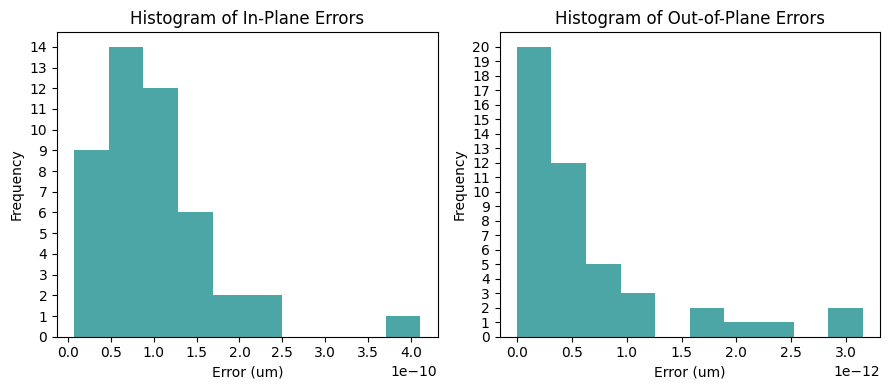

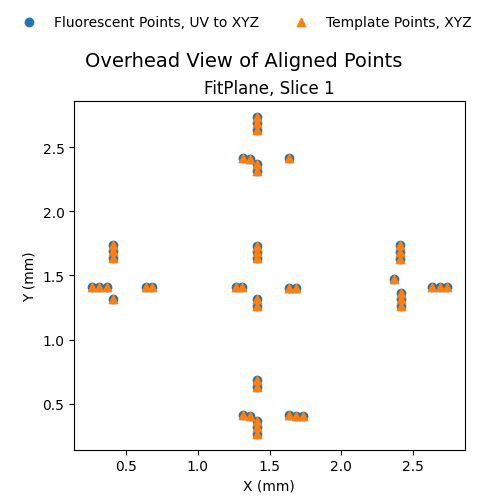

In [30]:
# @title Plot average error and overhead view of aligned points

def plot_error_histogram(in_plane_err_mm_per_point, out_plane_err_mm_per_point):
  # Flatten lists
  in_plane_err_values = np.hstack(in_plane_err_mm_per_point) * 1000  # Convert to um
  out_plane_err_values = np.hstack(out_plane_err_mm_per_point) * 1000

  plt.figure(figsize=(9, 4))

  # Subplot 1: In-Plane Error Histogram
  plt.subplot(1, 2, 1)
  counts, bins, patches = plt.hist(in_plane_err_values, bins=10, color='teal', alpha=0.7)
  plt.xlabel('Error (um)')
  plt.ylabel('Frequency')
  plt.title('Histogram of In-Plane Errors')
  plt.yticks(np.arange(0, max(counts) + 1, step=1))

  # Subplot 2: Out-of-Plane Error Histogram
  plt.subplot(1, 2, 2)
  counts, bins, patches = plt.hist(out_plane_err_values, bins=10, color='teal', alpha=0.7)
  plt.xlabel('Error (um)')
  plt.ylabel('Frequency')
  plt.title('Histogram of Out-of-Plane Errors')
  plt.yticks(np.arange(0, max(counts) + 1, step=1))  # Set y-axis to integers

  plt.tight_layout()
  plt.show()

def plot_overhead_view(slice_idx, template_points_xyz_mm_all_planes, fluorescent_points_uv_pix_all_planes, fps_elastic):
    num_slices = len(slice_idx)
    cols = min(3, num_slices)  # Display in up to 3 columns
    rows = (num_slices // cols) + (num_slices % cols > 0)  # number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows), constrained_layout=True)
    axes = np.array(axes).reshape(-1)  # Flatten axes in case of single row/column

    # Store plot handles for a common legend
    handles, labels = [], []

    for idx, (slice_num, ax) in enumerate(zip(slice_idx, axes)):
        template_points_xyz_mm = template_points_xyz_mm_all_planes[idx]
        fluorescent_points_uv_pix = fluorescent_points_uv_pix_all_planes[idx]
        fp = fps_elastic[idx]

        # Convert UV points to XYZ
        a = np.array([fp.get_xyz_from_uv(t) for t in fluorescent_points_uv_pix]).squeeze()

        # Plot points
        h1 = ax.scatter(a[:,0], a[:,1], label="Fluorescent Points, UV to XYZ")
        h2 = ax.scatter(template_points_xyz_mm[:, 0], template_points_xyz_mm[:, 1],
                        label="Template Points, XYZ", marker='^')

        # Collect handles for global legend (only once)
        if idx == 0:
            handles.extend([h1, h2])
            labels.extend(["Fluorescent Points, UV to XYZ", "Template Points, XYZ"])

        ax.set_xlabel("X (mm)")
        ax.set_ylabel("Y (mm)")
        ax.set_title(f"FitPlane, Slice {slice_num}")

    # Hide unused subplots if slices < total grid size
    for ax in axes[num_slices:]:
        ax.axis("off")

    # Add one common legend outside the subplots
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, frameon=False)

    plt.suptitle("Overhead View of Aligned Points", fontsize=14)
    plt.show()

plot_error_histogram(in_plane_err_mm_per_point, out_plane_err_mm_per_point)
plot_overhead_view(slice_idx, template_points_xyz_mm_all_planes, fluorescent_points_uv_pix_all_planes, fps_elastic)

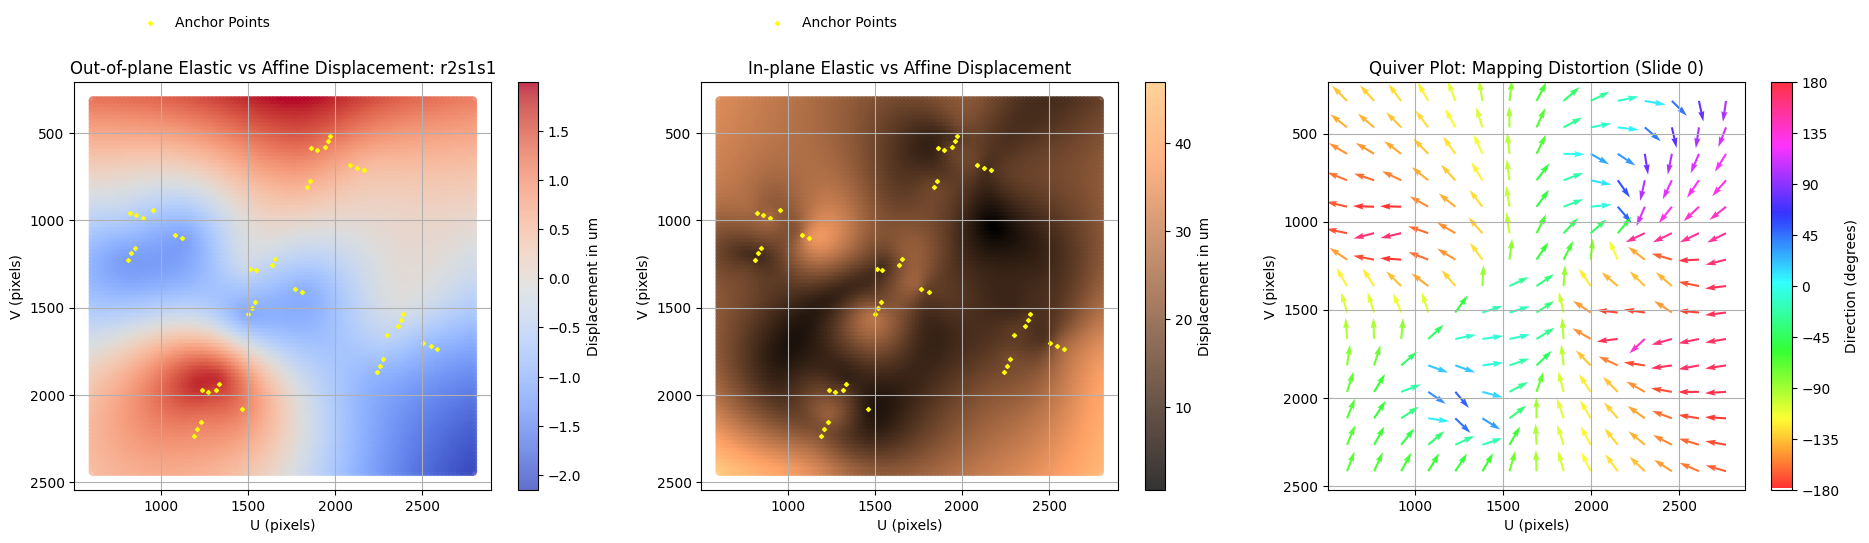

In [46]:
# @title Plot Distortion Magnitude and Direction
def plot_mapping_distortion(fps_elastic, fps_affine, fluorescent_image_points_uv_pix_all_planes, image_shape=None):
    for idx, (fp_elastic, fp_affine, fluorescent_image_points_uv_pix) in enumerate(zip(fps_elastic, fps_affine, fluorescent_image_points_uv_pix_all_planes)):
        # Create a grid of uv points
        # Since images are not required for this notebook to run, if no image shape is specified, set plot axes = 0 to maximum provided point value
        if image_shape == None:
            u_max = max(fluorescent_image_points_uv_pix[:, 0])
            v_max = max(fluorescent_image_points_uv_pix[:, 1])
            u_max = math.ceil(u_max) + 200
            v_max = math.ceil(v_max) + 200
            u_min = math.ceil(min(fluorescent_image_points_uv_pix[:, 0])) - 200
            v_min = math.ceil(min(fluorescent_image_points_uv_pix[:, 1])) - 200
        else:
            u_max = image_shape[0]
            v_max = image_shape[1]
            u_min = 0
            v_min = 0

        u = np.linspace(u_min, u_max, 100)
        v = np.linspace(v_min, v_max, 100)
        u_grid, v_grid = np.meshgrid(u, v)
        uv_grid_points = np.column_stack((u_grid.ravel(), v_grid.ravel()))  # Flatten to (N, 2)

        # Interpolate uv grid points to xyz space
        xyz_interpolated_elastic = fp_elastic.get_xyz_from_uv(uv_grid_points)
        xyz_interpolated_affine = fp_affine.get_xyz_from_uv(uv_grid_points)

        # Compute displacement in um
        displacement_vec = xyz_interpolated_elastic - xyz_interpolated_affine
        in_plane_displacement = np.dot(displacement_vec, fp_affine.normal_direction()) # (N,)
        out_of_plane_displacement = np.sqrt(np.linalg.norm(displacement_vec, axis=-1) ** 2 - in_plane_displacement ** 2)
        in_plane_displacement = in_plane_displacement * 1000
        out_of_plane_displacement = out_of_plane_displacement * 1000

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))

        # Plot out of plane difference between elastic and affine

        # Heatmap of Displacement (um)
        heatmap = ax1.scatter(
            uv_grid_points[:, 0],
            uv_grid_points[:, 1],
            c=in_plane_displacement,
            cmap='coolwarm',
            alpha=0.8,
        )
        ax1.scatter(fluorescent_image_points_uv_pix[:,0], fluorescent_image_points_uv_pix[:,1], s=4, marker='D', color="yellow", label="Anchor Points")
        ax1.set_xlabel('U (pixels)')
        ax1.set_ylabel('V (pixels)')
        name = "r2s1s1"
        ax1.set_title(f'Out-of-plane Elastic vs Affine Displacement: {name}')
        ax1.grid(True)
        ax1.legend(loc="lower right", bbox_to_anchor=(0.5, 1.1), frameon=False)
        ax1.set_aspect('equal')
        ax1.invert_yaxis()
        fig.colorbar(heatmap, ax=ax1, label='Displacement in um')

        # Plot in-plane difference between elastic and affine

        heatmap2 = ax2.scatter(
            uv_grid_points[:, 0],
            uv_grid_points[:, 1],
            c=out_of_plane_displacement,
            cmap='copper',
            alpha=0.8,
        )
        ax2.scatter(fluorescent_image_points_uv_pix[:,0], fluorescent_image_points_uv_pix[:,1], s=4, marker='D', color="yellow", label="Anchor Points")
        ax2.set_xlabel('U (pixels)')
        ax2.set_ylabel('V (pixels)')
        ax2.set_title(f'In-plane Elastic vs Affine Displacement')
        ax2.grid(True)
        ax2.legend(loc="lower right", bbox_to_anchor=(0.5, 1.1), frameon=False)
        ax2.set_aspect('equal')
        ax2.invert_yaxis()
        cbar = fig.colorbar(heatmap2, ax=ax2, label='Displacement in um')
        # Force plain formatting (no scientific notation)
        cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        cbar.ax.yaxis.get_major_formatter().set_scientific(False)
        cbar.ax.yaxis.get_major_formatter().set_useOffset(False)

        # Plot direction of difference between elastic and affine

        # Normalize the vectors
        dx = displacement_vec[:, 0]
        dy = displacement_vec[:, 1]
        magnitudes = np.sqrt(dx**2 + dy**2)
        dx_normalized = dx / (magnitudes + 1e-8)
        dy_normalized = dy / (magnitudes + 1e-8)

        # Compute angles in degrees
        angles = np.arctan2(dy, dx)
        angles_deg = np.rad2deg(angles)

        step = 7

        # Reshape dx/dy/angle into 2D (same shape as U and V)
        height, width = u_grid.shape  # or use len(v), len(u)
        dx_2d = dx_normalized.reshape((height, width))
        dy_2d = dy_normalized.reshape((height, width))
        angle_2d = angles_deg.reshape((height, width))

        # Subsample everything in 2D
        U_sub = u_grid[::step, ::step]
        V_sub = v_grid[::step, ::step]
        dx_sub = dx_2d[::step, ::step]
        dy_sub = dy_2d[::step, ::step]
        angle_sub = angle_2d[::step, ::step]

        # Plot
        quiver = ax3.quiver(
            U_sub,
            V_sub,
            dx_sub * 120,
            dy_sub * 120,
            angle_sub,
            cmap='hsv',
            angles='xy',
            scale_units='xy',
            scale=1,
            alpha=0.8,
            width=0.005,
            headwidth=3,
        )

        ax3.set_xlabel('U (pixels)')
        ax3.set_ylabel('V (pixels)')
        ax3.set_title(f'Quiver Plot: Mapping Distortion (Slide {idx})')
        ax3.grid(True)
        ax3.invert_yaxis()
        ax3.set_aspect('equal')

        # Colorbar showing direction in degrees
        cbar = fig.colorbar(quiver, ax=ax3, label='Direction (degrees)')
        cbar.set_ticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])

        plt.tight_layout()
        plt.savefig("displacement_plot.png",dpi=300, bbox_inches='tight')
        plt.show()

plot_mapping_distortion(fps_elastic, fps_affine, fluorescent_points_uv_pix_all_planes)

In [32]:
# @title Plot all best fit planes in 3D

def plot_multiple_planes(planes_points):
    """Plots multiple best-fit planes from given sets of 3D points in an interactive plot."""

    fig = go.Figure()
    colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Reds']
    colors_points = ['blue', 'brown', 'ForestGreen', 'purple', 'burgundy']

    for idx, points in enumerate(planes_points):
        # Compute best-fit plane
        centroid = np.mean(points, axis=0)
        centered_points = points - centroid
        _, _, vh = np.linalg.svd(centered_points)
        normal = vh[-1]

        # Ensure the normal is pointing upwards (positive Z-component)
        if normal[2] < 0:
            normal = -normal

        A, B, C = normal
        D = -np.dot(normal, centroid)

        # Define grid for plane
        xlim, ylim = np.ptp(points[:, 0]), np.ptp(points[:, 1])
        xx, yy = np.meshgrid(
            np.linspace(np.min(points[:, 0])-0.2*xlim, np.max(points[:, 0])+0.2*xlim, 20),
            np.linspace(np.min(points[:, 1])-0.2*ylim, np.max(points[:, 1])+0.2*ylim, 20)
        )
        zz = (-A * xx - B * yy - D) / C  # Solve for z in Ax + By + Cz + D = 0

        # Plot the plane
        fig.add_trace(go.Surface(
            x=xx, y=yy, z=zz,
            colorscale=colors[idx % len(colors)],  # Cycle through colors
            opacity=0.5,
            showscale=False,
            name=f'Plane {idx+1}'
        ))

        # Plot the points
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(size=5, color=colors_points[idx % len(colors_points)], opacity=0.8),
            name=f'Slice {idx+1}'
        ))

    # Set axis labels and improve visibility
    fig.update_layout(
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            aspectmode='auto'
        ),
        title="Multiple Best-Fit Planes with 3D Points (Interactive)",
    )

    # Show interactive plot
    fig.show()

plot_multiple_planes(template_points_xyz_mm_all_planes)